# Processing raw data
This section combines the raw data, the adjustments and cleaned bars to get processed 1-minute data. After processing we also detect the halts to create a <code>halted</code> flag. There are no gaps for processed data. All stocks that are active on a certain day have minute bars for every minute, from pre to post market, even if no trades took place. Empty bars are forward filled. Only for the first day, backwards filling may be done.

The steps:
1. The bars are cleaned first, because the cleaned data is derived from raw tick data.
2. Then the bars are split and dividend adjusted.
3. After this, the data is forward filled.
4. Lastly, halts are detected to create the flag.
5. The true start/end dates are determined for each stock.

In [1]:
from utils import get_tickers
from datetime import datetime, timedelta, date
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
DATA_PATH = "../../../data/polygon/"

In [2]:
all_files = os.listdir(f'{DATA_PATH}raw/m1/')
for file in all_files:
    ticker = file[:-19] # Remove date and parquet extension
    
    if ticker != "TSLA":
        continue
        
    bars = pd.read_parquet(f"{DATA_PATH}raw/m1/{file}")
    
    # CLEANING
    # if os.path.isfile(DATA_PATH + f"raw/cleaned/{ticker}.csv"):
    #     clean_bars = pd.read_csv(DATA_PATH + f"raw/cleaned/{ticker}.csv", parse_dates=True, index_col=0)
    #     bars.update(clean_bars)

    # ADJUSTING
    adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)

    # FORWARD FILLING

    # HALT DETECTION

    break

The steps for split and dividend adjustment are:
1. Get cumulative adjustment
2. Reindex adjustments using list of dates of stock
3. Multiply the bars ohlc and splits cumulative amount.
4. Adjust dividends for splits
5. Adjust prices for dividends using the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) method.

## Split adjustment example for TSLA

In [3]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/TSLA.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/TSLA-2019-01-01.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date
splits = adjustments[adjustments.type == "SPLIT"]

In [4]:
splits

,type,subtype,amount
2020-08-31,SPLIT,N,0.200000
2022-08-25,SPLIT,N,0.333333


In [5]:
trading_dates_ticker = np.unique(bars.index.date)

# The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
splits = splits.drop(columns=['type', 'subtype', 'amount'])
splits

,cumulative_adjustment
2020-08-31,0.066667
2022-08-25,0.333333


In [6]:
splits.index = splits.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [7]:
splits[splits.index > date(2022, 8, 20)][:5]

,cumulative_adjustment
2022-08-22,0.333333
2022-08-23,0.333333
2022-08-24,0.333333
2022-08-25,1.000000
2022-08-26,1.000000


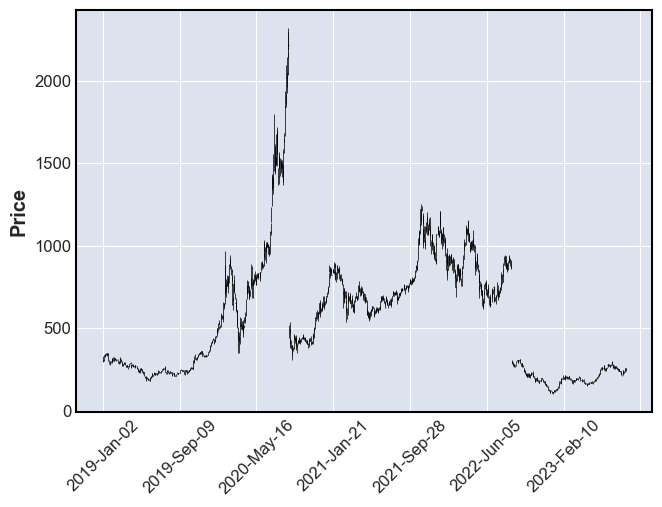

In [8]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [9]:
bars['date'] = bars.index.date
bars = bars.merge(splits, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")

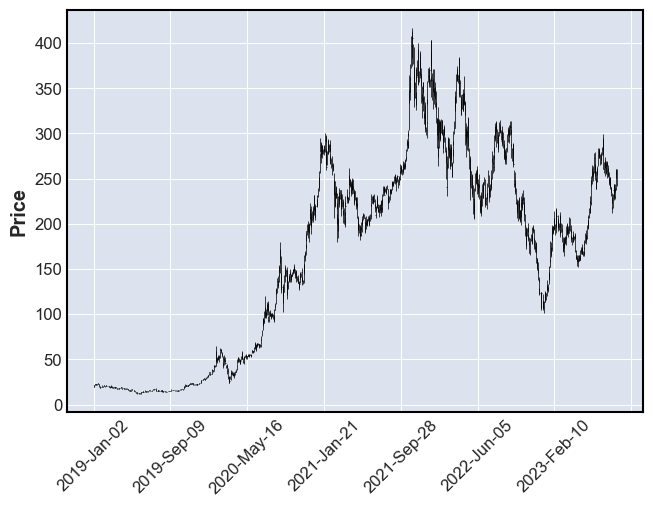

In [10]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

We also have to split-adjust the dividends, if there are splits.

In [11]:
dividends = adjustments[adjustments.type == "DIV"]
dividends

,type,subtype,amount


In [12]:
dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
dividends = dividends[['cum_div_date', 'amount']]
dividends = dividends.merge(splits, left_on='cum_div_date', right_index=True, how='left')
dividends['amount'] = dividends['amount'].multiply(dividends["cumulative_adjustment"], axis="index")

In [13]:
dividends

,cum_div_date,amount,cumulative_adjustment


## Dividend adjustment example for BIL
There is no single way to adjust for dividends. We use the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) or [Yahoo](https://help.yahoo.com/kb/SLN28256.html) method, which mimics dividend reinvesting at the close of cum-dividend date. If at cum-dividend the price is 60, and at ex-dividend is 50 after a 10/share dividend, then all prices from cum-dividend and before are adjusted by the factor *1 - (dividend/cumdividend close)*. So the adjusted cum-dividend close will be 50. 

Note: Even though the close (which can differ on early close days) is used to calculate the adjustment factor, the post-market prices also have to be adjusted. 

In [14]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/BIL.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL-2019-01-01.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date

dividends = adjustments[adjustments.type == "DIV"]
dividends.index.names = ['ex_div_date']

trading_dates_ticker = np.unique(bars.index.date)
dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
dividends.reset_index(inplace=True)
dividends.set_index(dividends['cum_div_date'], inplace=True)
dividends = dividends[['ex_div_date', 'amount']]
# Split adjust the dividends if necessary here

In [15]:
dividends.head(3)

,ex_div_date,amount
cum_div_date,,
2019-01-31,2019-02-01,0.179207
2019-02-28,2019-03-01,0.170000
2019-03-29,2019-04-01,0.175557


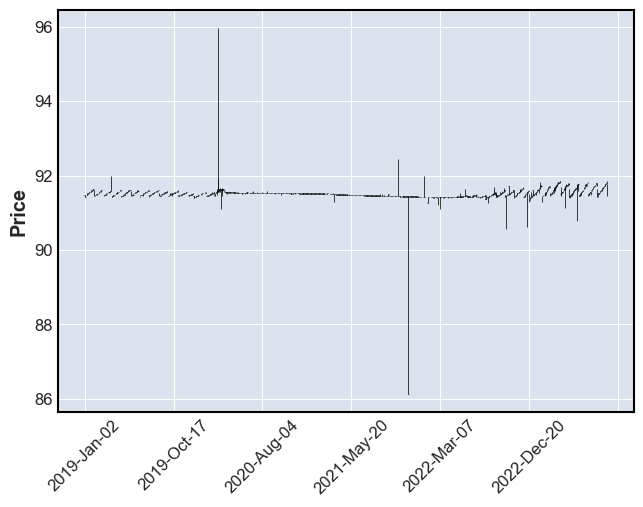

In [16]:
# Should be done on the split-adjusted prices
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [17]:
# We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
market_hours = pd.read_csv(DATA_PATH + "../other/market_hours.csv", index_col=0)
market_hours.index = pd.to_datetime(market_hours.index).date
market_hours.regular_close = pd.to_datetime(market_hours.regular_close).dt.time

C:\Users\Nathan\AppData\Local\Temp\ipykernel_34848\284601016.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  market_hours.regular_close = pd.to_datetime(market_hours.regular_close).dt.time


In [18]:
dividends['cum_div_time'] = market_hours.loc[dividends.index, 'regular_close']
dividends['cum_div_date'] = dividends.index
dividends.index = pd.to_datetime(dividends['cum_div_date'].astype(str) +' '+ dividends['cum_div_time'].astype(str))
dividends.drop(columns='cum_div_time', inplace=True)

dividends.index = dividends.index.to_series().apply(lambda datetime_ : max(bars[bars.index <= datetime_].index)) # Get latest available price at or before close. Slow for some reason.
dividends.index.names = ['cum_div_datetime']

dividends['cum_div_close'] = bars.loc[dividends.index, 'close']
dividends['adjustment'] = 1 - (dividends['amount'] / dividends['cum_div_close'])
dividends['cumulative_adjustment'] = dividends['adjustment'][::-1].cumprod()

In [19]:
dividends.set_index(dividends['cum_div_date'], inplace=True, drop=True)
dividends = dividends[['cumulative_adjustment']]
trading_dates_ticker = np.unique(bars.index.date)
dividends = dividends.reindex(trading_dates_ticker) # Reindex using stock data 
dividends.cumulative_adjustment = dividends.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [20]:
dividends.head(3)

,cumulative_adjustment
cum_div_date,
2019-01-02,0.934335
2019-01-03,0.934335
2019-01-04,0.934335


In [21]:
# Same procedure as with split adjustments
bars['date'] = bars.index.date
bars = bars.merge(dividends, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")

bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)
bars = round(bars, 4)

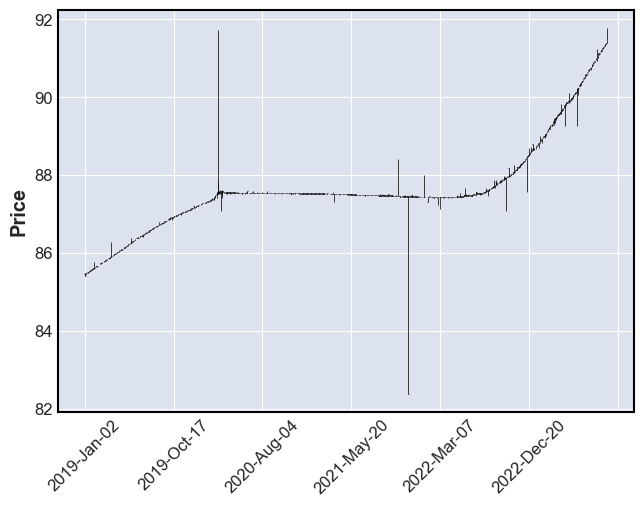

In [22]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

If you wonder why we don't just download adjusted prices: Every time we update our data we have to readjust the entire stock history. Then it's easier to use unadjusted prices, which will also gives less rounding errors. Also according to Polygon the prices the adjusted prices are only split-adjusted. 

Also, when we have fundamentals or other data that is unadjusted or adjusted we now know how to do it.